# Проект Анализ оттока клиентов «Метанпромбанк»

<h1 style="font-size: 24px;">Описание проекта</h1>

Проект представляет собой анализ динамики оттока клиентов банка, с возможностью дальнейшего удержания клиентов, определение причин возможного оттока клиентов, а также возможных рекомендаций по завершении проекта

<h1 style="font-size: 24px;">Цели</h1>

* Идентификация причин оттока клиентов
* Сегментация клиентов на группы наиболее склонных к оттоку
* Рекомендации о инсайтах и мерах удержания клиентов

<h1 style="font-size: 24px;">Задачи проекта</h1>

1. Загрузка и описание данных


2. Подготовка данных
- обработка пропущенных значений
- анализ явных и неявных дубликатов

3. Исследовательский анализ данных
- построить распределения данных в разрезе оттока клиентов
- проанализировать поведение ушедших клиентов и сравнить с теми кто остался
- составить корреляцию признаков наиболее влияющих на отток клиента

4. Проверка статистических гипотез 
- уровень оттока клиентов разный для состоятельных и несостоятельных клиентов
- уровень оттока клиентов разный для активных и неактивных клиентов

5. Промежуточные итоги

6. Сегментация групп клиентов склонных к оттоку


7. Приотеризация сегментов по значимости для банка

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Загрузка и описание данных

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from scipy.stats import ttest_ind, mannwhitneyu, levene, kstest,probplot, normaltest
from statsmodels.stats.proportion import proportions_ztest

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Заметим в столбцах age и balance пропущенные значения, при чем в столце balance пропущенная значительная часть. Разберемся что делать с пропущенными значениями позже. Типы данных приведены корректно

In [5]:
df.rename(columns={'USERID':'user_id', 'EST_SALARY':'est_salary'}, inplace=True)
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

Превели все названия столбцов к нижнему регистру

### Подготовка данных

In [6]:
df['age_missing'] = df['age'].isna().astype('int')
df['balance_missing'] = df['balance'].isna().astype('int')

Введем дополнительные переменные отражающие отсутствие признака

In [7]:
df_copy = pd.get_dummies(df, columns=['city', 'gender'])
df_copy = df_copy.drop(columns=['user_id', 'age', 'balance']).corr()[['age_missing', 'balance_missing']]
df_copy.sort_values(by=['age_missing', 'balance_missing'])

,age_missing,balance_missing
products,-0.033751,-0.487512
equity,-0.032040,-0.709951
churn,-0.018994,-0.249421
city_Ростов,-0.015114,-0.061508
city_Ярославль,-0.009214,0.055919
gender_Ж,-0.003876,-0.063424
gender_М,0.003876,0.063424
score,0.005035,0.138871
credit_card,0.009726,0.158334
est_salary,0.011252,0.307154


In [8]:
print('Процент пропущенных значений',float(100 - (df['balance'].count() / df.shape[0] * 100)), '%')

Процент пропущенных значений 22.950000000000003 %


Нельзя проследить четкой корреляции между отсутствием возраста и другими переменными, также их небольшое число не приведет к потере информации. Можно отбросить строки их потеря не отразится на качестве. Другая ситуация возникает с переменной balance_missing, корреляция показывает, что существует сильная отрицательная связь с переменной equity -0.71 и products -0.48 соответсвенно, то есть чем больше у клиента продуктов и имущества, тем меньше шанс, что его баланс будет отсутсвовать. Исходя из высокого шанса исказить данные, оставим пропуски в столбце balance

Исходя из приведенной выше кореляции сделаем вывод, что пропуски age относятся к MCAR (Missing Completely At Random) так как нет заметной корреляции между пропуском и другими признаками, тогда как пропуски balance зависят от других признаков, следовательно их можно присвоить к класификации MNAR (Missing Not At Random)

In [9]:
df = df.drop(index=df[df['age'].isna()].index).reset_index(drop=True)
df.shape

(9974, 14)

Проверим данные на явные и не явные дубликаты

In [10]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено

In [11]:
df[df['user_id'].duplicated(keep=False)].sort_values(by='user_id').head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_missing,balance_missing
1892,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,0
7683,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,0,1
4862,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,0
7531,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,0,1
5856,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,0
5889,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,0,1
1410,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,0,0
8621,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,0,1
9750,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0,0
8151,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,0,0


В датафрейме присутствует 100 дубликатов по user_id, однако по столбцам данных можно заметить, что значения отличаются. Скорее всего произошел сбой системы и разным клиентам присвоили одинаковые user_id. Не станем удалять данные, так как они не являются полной копией

Промежуточный вывод: Провели анализ пропущенных значений, привели столбцы к змеинному регистру, рассмотрели данные на дубликаты

### EDA

#### Распределения

Прежде чем начать анализировать данные нужно проверить данные на выбросы, построим распределения

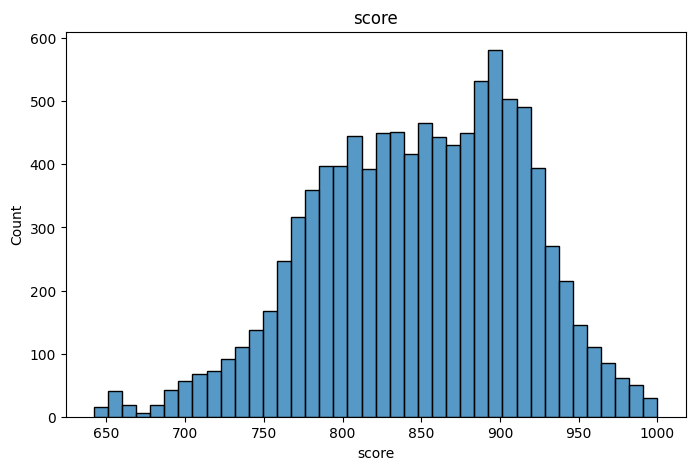

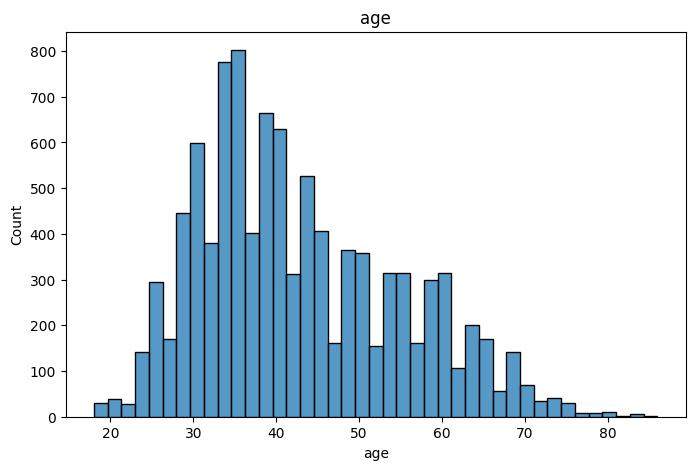

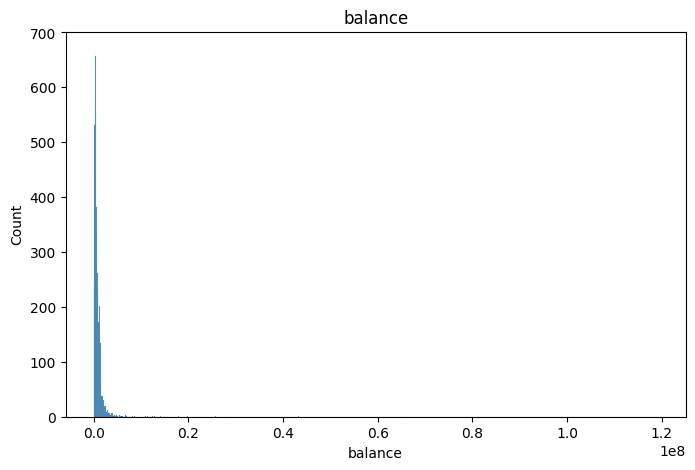

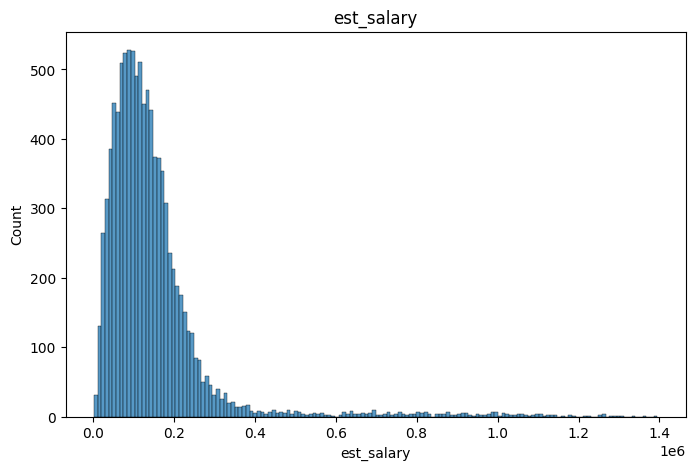

In [12]:
numeral = ['score', 'age',  'balance', 'est_salary']
for i in numeral:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=i)
    plt.title(i)
    plt.show()

На графиках видно, что est_salary и balance имеют выбросы перекашивающие график распределения

In [13]:
def cut_quant(df, i):
    pre = df.shape[0]
    df=df.drop(df[df[i].quantile(0.99) <= df[i]].index).reset_index(drop=True)
    print('Количество строк', df.shape[0], ' процент потери', 100 - (df.shape[0]/pre*100))
    sns.histplot(data=df[i])
    plt.show()
    return df

Количество строк 9897  процент потери 0.7720072187688061


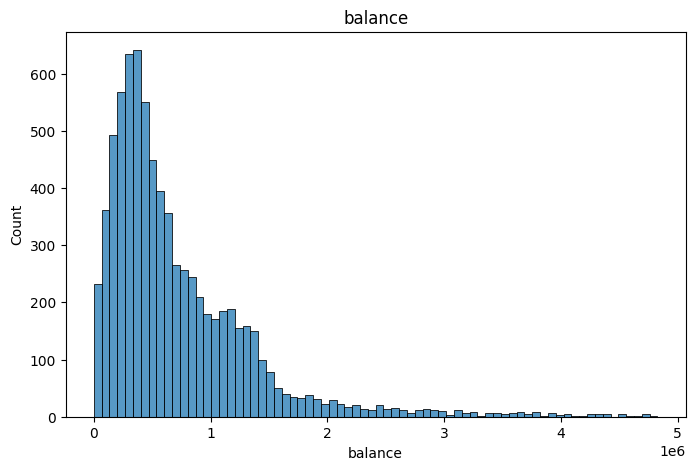

Количество строк 9798  процент потери 1.000303122158229


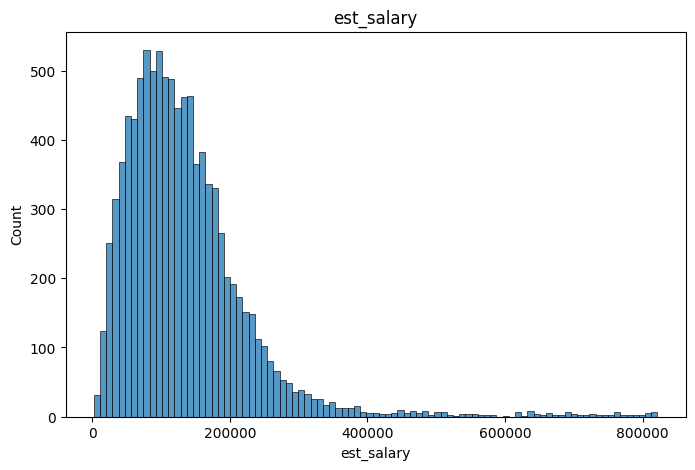

In [14]:
for i in ['balance', 'est_salary']:
    plt.figure(figsize=(8,5))
    plt.title(i)
    df = cut_quant(df, i)

Мы исключили выбросы из столбцов est_salary и balance, процент утечки данных в допустимых значениях, менее 5%

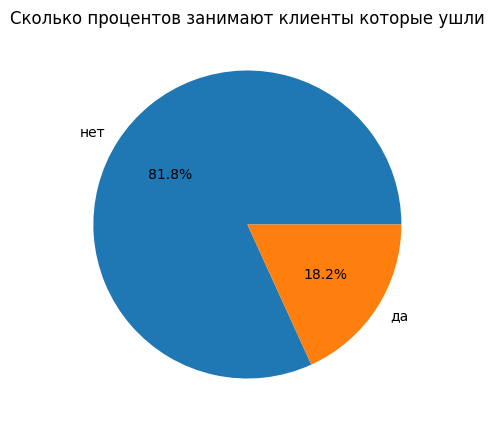

In [15]:
plt.figure(figsize=(8,5))
plt.pie(df['churn'].value_counts(), labels=['нет','да'], autopct='%1.1f%%')
plt.title('Сколько процентов занимают клиенты которые ушли')
plt.show()

По распределению видно, что примерно ушли 18,2% Теперь нужно проанализировать данные ушедших клиентов и постараться скорнцентрироваться на удержании целевых сегментов

#### Распределения исходя из оттока

Рассмотрим распределение непрерывных переменных исходя из оттока клиентов

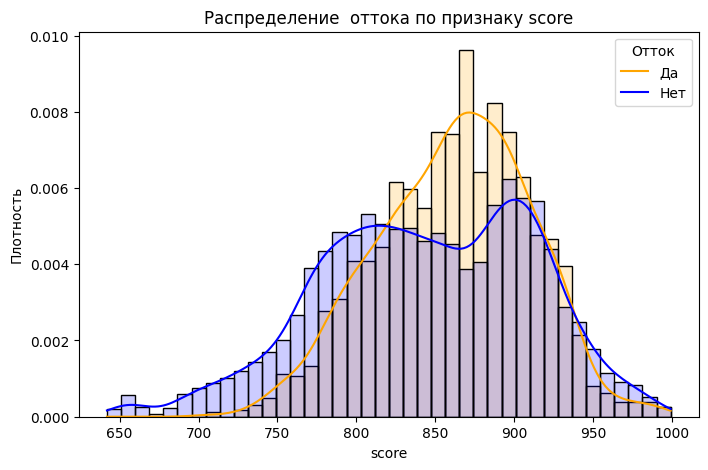

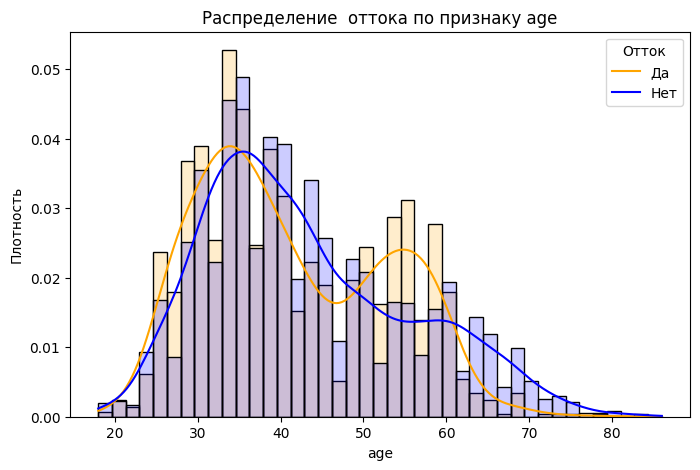

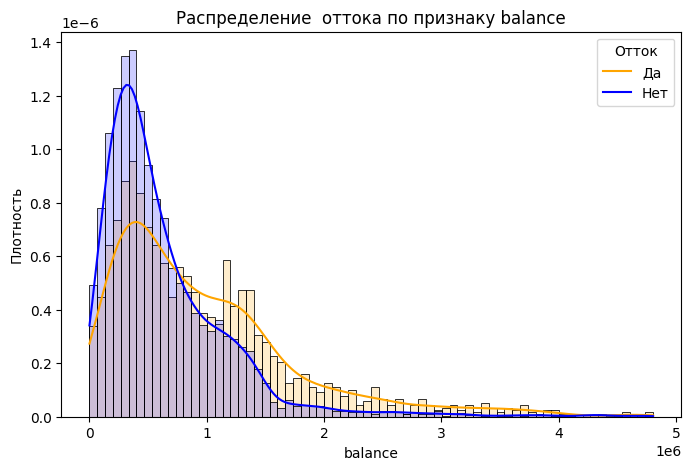

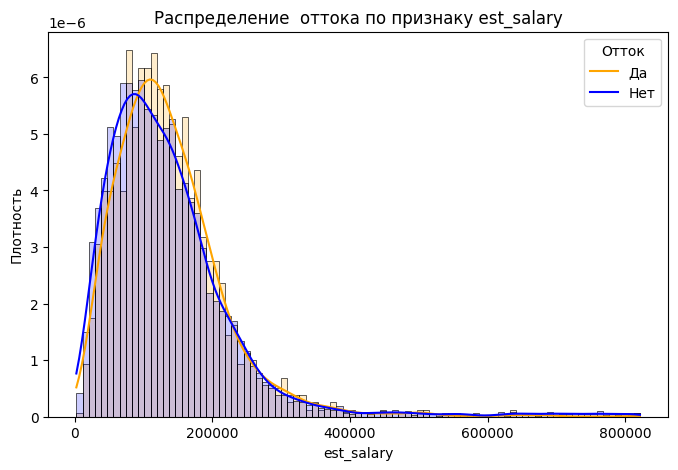

In [16]:
for i in numeral:
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x=i, hue='churn', common_norm=False, alpha=0.2, palette=['blue', 'orange'], kde=True, stat='density')
    plt.title(rf'Распределение  оттока по признаку {i}')
    plt.xlabel(i)
    plt.legend(title='Отток', labels=['Да', 'Нет'])
    plt.ylabel('Плотность')
    plt.show()

Исходя из построенных диаграмм можно сделать следущие выводы:
* от 830 баллов до 900 баллов по признаку score можно выделить значительный отток клиентов
* клиенты в возрасте от 25-35 лет и в возрасте 50-60 лет уходят чаще остальных
* в значительной степени преобладает уход клиентов со счетом баланса выше 1 млн рублей
* наблюдается повышенный отток у клиентов с зарплатой около 100 тысяч до 250 тысяч.

Проанализируем дискретные переменные

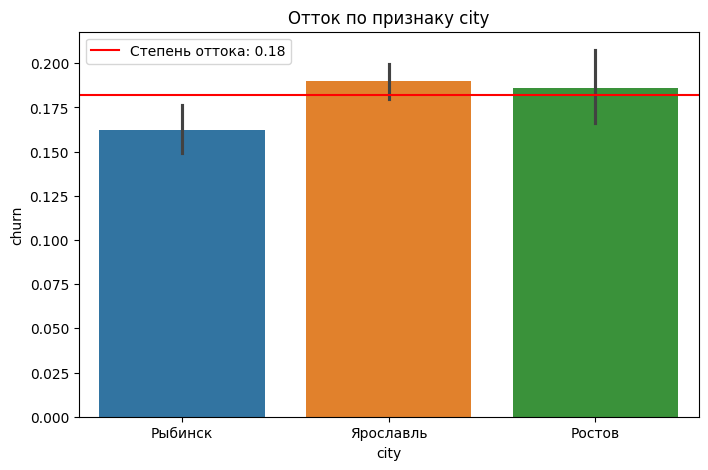

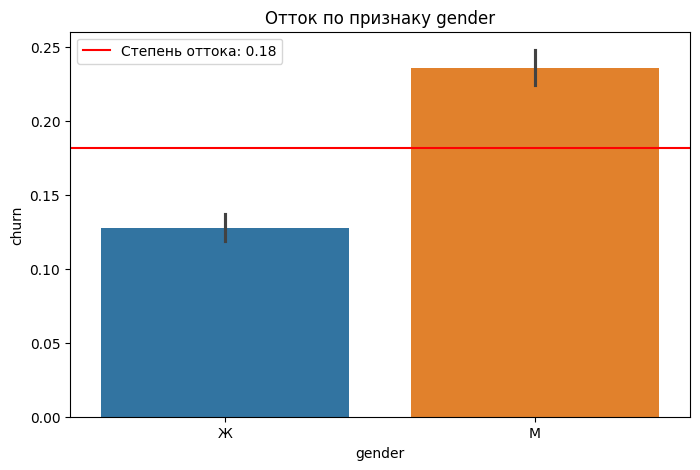

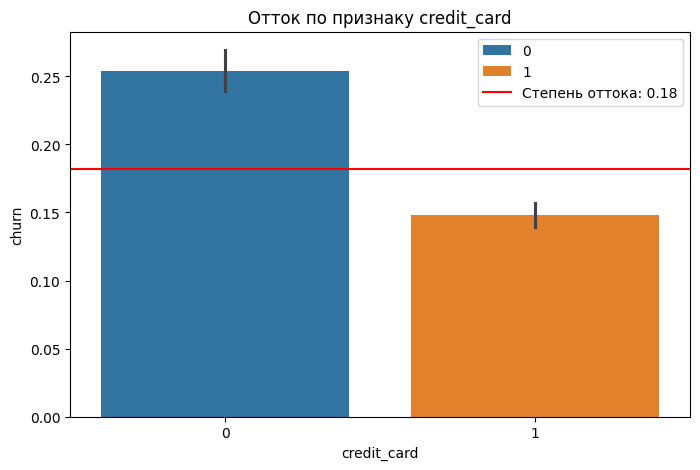

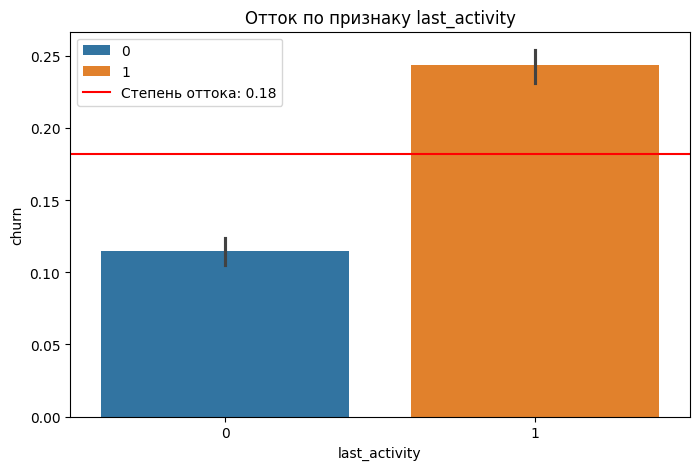

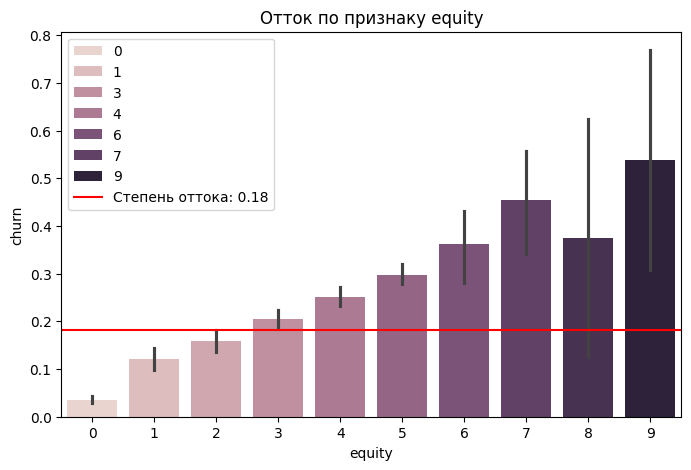

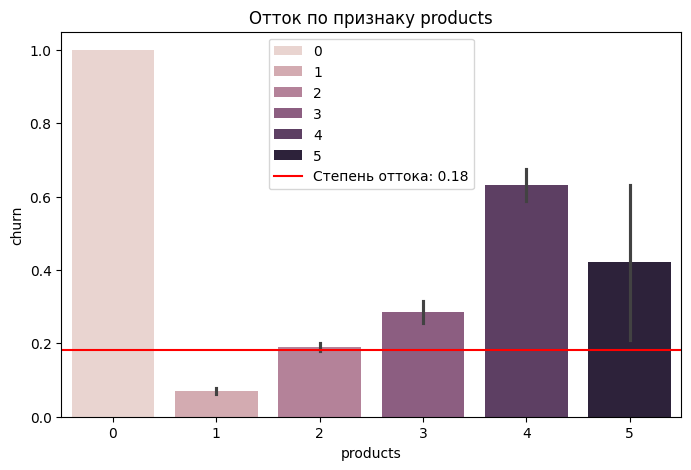

In [17]:
vars = ['city', 'gender', 'credit_card', 'last_activity', 'equity', 'products']
churn_mean = df['churn'].mean()
for var in vars:
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x=var, y='churn', hue=var)
    plt.title(f'Отток по признаку {var}')
    plt.axhline(churn_mean, color='red', label=f'Степень оттока: {churn_mean:.2f}')
    plt.legend()
    plt.show()

После анализа сделаем вывод что больше всего людей уходят из Ярославля и Ростова, клиенты из Рыбинска ниже порога ухода. По полу чаще всего мужчины уходят из банка, без кредитных карт, активные, с количеством продуктов больше 2 и значением equity больше 3. То есть уходят клиенты активные, использущие продукты банка и с большим количеством очков equity. 

Заметим аномалию, в данных присутствуют клиенты не имеющие банковских продуктов, однако они участвуют в анализе. Удалим данные, если это не приведет к заметной утечке

In [18]:
df = df.drop(index = df.loc[df['products'] == 0].index).reset_index(drop=True)
df.shape

(9797, 14)

#### Анализ корреляции между переменными

Согласно шкале Чеддока корреляцию можно разбить на слабую 0.1-0.3, умеренную 0.3-0.5, заметную 0.5-0.7 и высокую 0.7-0.9 и весьма высокую 0.9-1. Сделаем выводы согласно этой классификации

churn             1.000000
products          0.299886
equity            0.267069
balance           0.222918
last_activity     0.167259
gender_М          0.141016
score             0.101998
city_Ярославль    0.025074
est_salary        0.006023
city_Ростов       0.004756
city_Рыбинск     -0.031520
age              -0.051627
credit_card      -0.128274
gender_Ж         -0.141016
Name: churn, dtype: float64

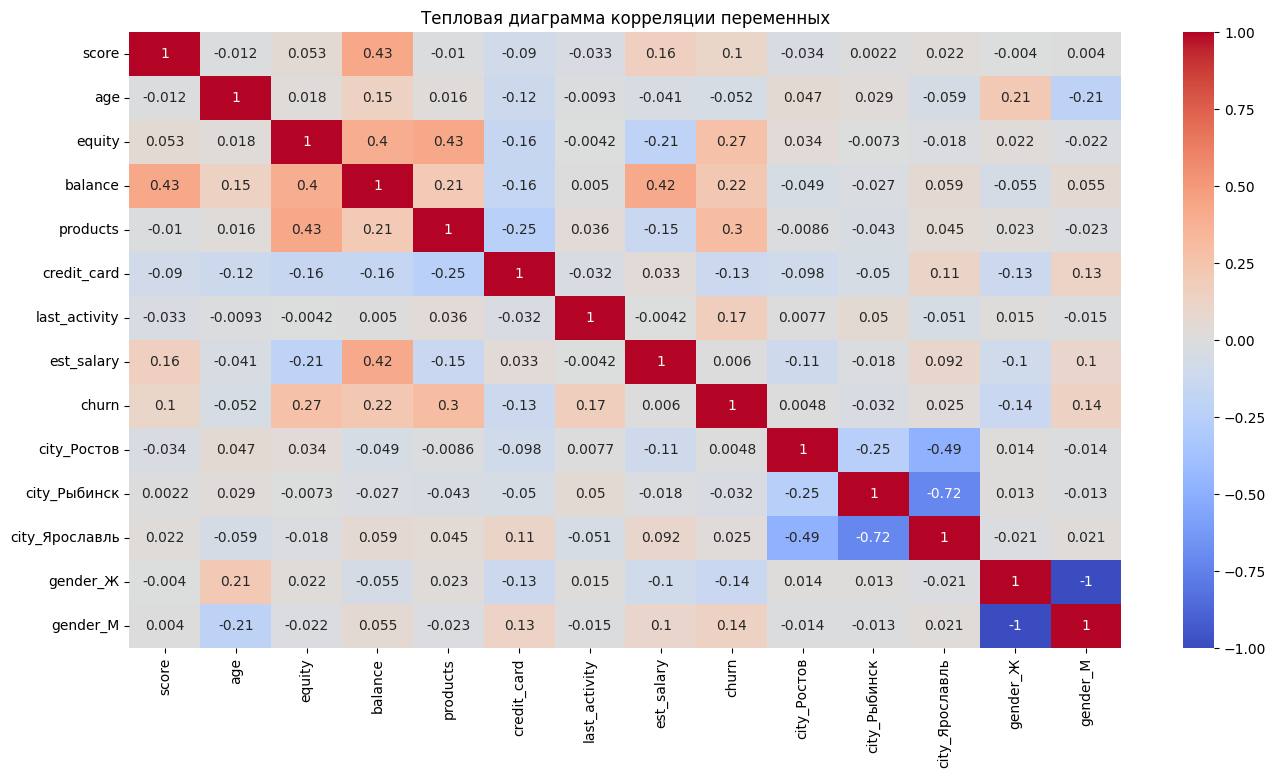

In [19]:
df_copy = pd.get_dummies(df, columns=['city', 'gender'])
df_copy = df_copy.drop(columns=['user_id', 'age_missing', 'balance_missing']).corr()
display(df_copy['churn'].sort_values(ascending=False))
plt.figure(figsize=(16,8))
sns.heatmap(df_copy, cmap='coolwarm', center=0, annot=True)
plt.title('Тепловая диаграмма корреляции переменных')
plt.show()

На тепловой диаграмме можно проследить умеренные положительные корреляции у balance и score - 0.43, balance и equity - 0.4, products и equity - 0.43. Для переменной оттока можно выделить умеренную положительную связь у products - 0.3, equity - 0.26 и balance - 0.22

Рассмотрим таблицу phik которая может находить нелинейные связи с переменными

In [20]:
phink_table = (df.drop(columns=['age_missing', 'user_id', 'balance_missing'])
               .phik_matrix(interval_cols= ['score','balance','est_salary','age']))

churn            1.000000
equity           0.347947
balance          0.305521
last_activity    0.258864
products         0.258721
score            0.231097
gender           0.218748
credit_card      0.199091
age              0.191714
est_salary       0.065503
city             0.017034
Name: churn, dtype: float64

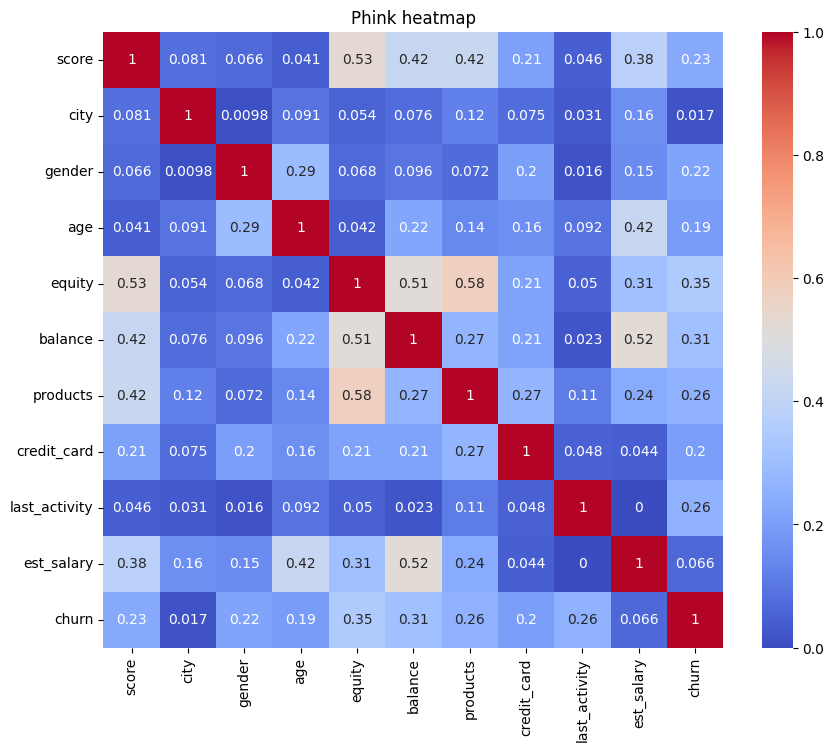

In [21]:
display(phink_table['churn'].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(phink_table, annot=True, cmap='coolwarm')
plt.title('Phink heatmap')
plt.show()

Phik таблица усиливает признаки product, balance, equity наделяя их еще более высокими значениями корреляции с переменной оттока. Выделим, что параметры product, balance и equity в приоритете.

#### Портрет клиента

In [22]:
churn_grouped = df.groupby('churn')

values = {
    'Средняя зарплата' : churn_grouped['est_salary'].mean(),
    'Средний возраст' : churn_grouped['age'].mean(),
    'Средний баланс' : churn_grouped['balance'].mean(),
    'Средний кредитный скоринг' : churn_grouped['score'].mean(),
    'Медианное количество продуктов' : churn_grouped['products'].median(),
    'Медианное количество собственности' : churn_grouped['equity'].median(),
    'Мода по городу' : churn_grouped['city'].apply(lambda x: x.mode()[0]),
    'Мода по полу' : churn_grouped['gender'].apply(lambda x: x.mode()[0]),
    'Мода по наличию кредитной карты' : churn_grouped['credit_card'].apply(lambda x: x.mode()[0]),
    'Мода по наличию активности' : churn_grouped['last_activity'].apply(lambda x: x.mode()[0])
}
table = pd.DataFrame(values).T
table.columns =  ['Не отток', 'Отток']
table['относительная разница разница']  = (
    table.apply(lambda x : (x[1]-x[0])/x[0]*100 if x.name not in ['Мода по городу',
                                                                  'Мода по полу',
                                                                  'Мода по наличию кредитной карты',
                                                                  'Мода по наличию активности'] else np.nan , axis=1)
                                          )
table

C:\Users\Admin\AppData\Local\Temp\ipykernel_23812\3431638182.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  table.apply(lambda x : (x[1]-x[0])/x[0]*100 if x.name not in ['Мода по городу',


,Не отток,Отток,относительная разница разница
Средняя зарплата,135139.328263,136639.160747,1.109842
Средний возраст,43.025075,41.391353,-3.797138
Средний баланс,633435.42789,971493.296475,53.368955
Средний кредитный скоринг,844.651447,861.72712,2.021624
Медианное количество продуктов,2.0,2.0,0.000000
Медианное количество собственности,3.0,4.0,33.333333
Мода по городу,Ярославль,Ярославль,NaN
Мода по полу,Ж,М,NaN
Мода по наличию кредитной карты,1,1,NaN
Мода по наличию активности,0,1,NaN


Опишем портрет ушедшего клиента и клиента который остался.

Клиент который ушел, имеет среднюю зарплату в 136 тысяч, средний возраст 41 год, средний баланс около 900 тысяч, медианное количество продуктов и собственности 2 и 4 соответсвенно, преймущественно мужского пола и из Ярославля. Также является активным клиентом и имеет кредитную карту, средний балл скоринга 861

Клиент который остался, имеет среднюю зарплату в 135 тысяч,средний возраст 43 года, средний баланс около 630 тысяч, медианное количество продуктов и собственности 2 и 3 соответсвенно, преймущественно женского пола и из Ярославля. Не является активным клиентом и имеет кредитную карту, средний балл скоринга 844

В целом есть различия в поле клиента, мужчины чаще уходят, более активные клиенты уходят из банка, а также существенно различается баланс клиента, у ушедших он на 53% выше чем у тех кто остался

### Проверка статистических гипотез

Разобьем выборки на две категории. Клиент ушел или пока нет

In [23]:
churn_yes = df[df['churn'] == 1]
churn_no = df[df['churn'] == 0]

In [24]:
def check_normality(data,feature ,churn_type,alpha=0.05):
    print(f'Количество данных в группе {churn_type}',len(data))
    stat, p = normaltest(data)
    probplot(data, dist="norm", plot=plt)
    plt.title(f"QQ-plot для оттока  {feature} {churn_type}", )
    plt.show()
    print("""Проверим нормальность распределения выбороки\n Сформируем гипотезы:\n
    H0 - распределение выборки соответсвует нормальному\n
    H1 - распределение выборки не является нормальным\n""")
    print(f"K-squared test: p-value = {p}")
    if p > alpha:
        print("Распределение нормальное (не отвергаем H0)")
        print("\033[95m" + "=" * 50 + "\033[0m") 
    else:
        print("Распределение не нормальное (отвергаем H0)")
        print("\033[95m" + "=" * 50 + "\033[0m") 
    return p

Для проверки распределения построим функцию, которая находит если данные распределены нормально по тесту Д’Агостино-Пирсона, который подходит для больших выборок, и также строит qq-plot который графически отображает перекосы распределения данных.

Сформулируем гипотезы для проверки нормальности распределения:
* H0 - распределение выборки является нормальным
* H1 - распределение выборки не является нормальным

In [25]:
def check_equal_variances(group1, group2, alpha=0.05):
    print("""Проверим равенство дисперсий двух выборок\n Сформируем гипотезы:\n
    H0 - дисперсии выборок одинаковые\n
    H1 - существует статистически значимая разница между дисперсиями выборок\n""")
    stat, p = levene(group1, group2)
    print(f"Levene's Test: p-value = {p}")
    if p > alpha:
        print("Дисперсии равны (не отвергаем H0)")
        print("\033[95m" + "=" * 50 + "\033[0m") 
    else:
        print("Дисперсии не равны (отвергаем H0)")
        print("\033[95m" + "=" * 50 + "\033[0m") 
    return p

Проверяем равенство дисперсии за счет теста Левена:
Формулируем гипотезы
* H0 - дисперсии не имеют статистически значимых различий
* H1 - дисперсии выборок статистически значимо отличаются от друг друга

In [26]:
def remove_outliers(data):
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data >= lower_bound) & (data <= upper_bound)]

Данная функция возвращает данные без выбросов, чтобы была возможность провести T-test. Точки данных, которые попадают ниже Q1 − 1,5 × IQR или выше Q3 + 1,5 × IQR, считаются выбросами. 

In [27]:
def analyze_continuous_feature(data_yes, data_no, feature):
    print(f"Анализ признака: {feature}")
    
    group_no = remove_outliers(data_no[feature].dropna())  # Не ушедшие клиенты без выбросов
    group_yes = remove_outliers(data_yes[feature].dropna())  # Ушедшие клиенты без выбросов
    
    # Информация о выбросах
    original_no = data_no[feature].dropna()
    original_yes = data_yes[feature].dropna()
    outliers_no = len(original_no) - len(group_no)
    outliers_yes = len(original_yes) - len(group_yes)
    
    print(f"\nВыбросы удалены: в группе 'Не ушедшие' - {outliers_no}, в группе 'Ушедшие' - {outliers_yes}")
    print(f"Осталось наблюдений: 'Не ушедшие' - {len(group_no)}, 'Ушедшие' - {len(group_yes)}")
    
    # Проверка нормальности распределения
    print("\nПроверка нормальности распределения:")
    p1 = check_normality(group_no, feature, 'churn_no')
    
    p2 = check_normality(group_yes, feature, 'churn_yes')
    
    # Проверка равенства дисперсий
    p_var = check_equal_variances(group_no, group_yes)
    
    print("""Выдвинем гипотезы: \n
    H0:статистически значимой разницы между выборками нет \n
    H1:у выборок есть статистически значимая разница \n""")    
    # Выбор теста
    if p1 > 0.05 and p2 > 0.05 and p_var > 0.05:  
        stat, p = ttest_ind(group_no, group_yes)
    else:  # Если дисперсии не равны
        print("\nИспользуем t-тест с поправкой Уэлча")
        stat, p = ttest_ind(group_no, group_yes, equal_var=False)
    
    print(f"Результат теста: p-value = {p}")
    if p > 0.05:
        print("Нет статистически значимых различий между группами")
        print("\033[95m" + "=" * 50 + "\033[0m") 
    else:
        print("Есть статистически значимые различия между группами")
        print("\033[95m" + "=" * 50 + "\033[0m") 

Построим функцию которая проверяет данные на нормальность, равенство дисперсии двух выборок и ищет между ними статистическую значимую разницу.

Сформулируем гипотезы о двух выборках:

* H0 - нет статистически значимой разницы между клиентами которые остались и которые ушли по выбранному признаку (признак не влияет ушел клиент или нет)
* H1 - есть статистически значимая разница между клиентами которые остались и которые ушли по выбранному признаку (признак влияет ушел клиент или нет)

Также хочется сказать что при отсутствии нормальности можно сделать поправку на ЦПТ, так как размер выборок данных в нашем случае это позволяет, тест Манна-Уитни работает с рангами и менее интерпритируем для бизнеса, так что предполчтенее отдаем two-sized Т-тесту

<h1 style="font-size: 16px;">гипотеза 1</h1> Зарплата клиентов которые ушли и которые остаются разная
Выдвинем гипотезы:

* H0: Нет статистически значимой разницы между зарплатой у клиентов которые ушли и которые остались
* H1: Присутствует статистически значимая разница между зарплатой групп


Анализ признака: est_salary

Выбросы удалены: в группе 'Не ушедшие' - 292, в группе 'Ушедшие' - 55
Осталось наблюдений: 'Не ушедшие' - 7724, 'Ушедшие' - 1726

Проверка нормальности распределения:
Количество данных в группе churn_no 7724


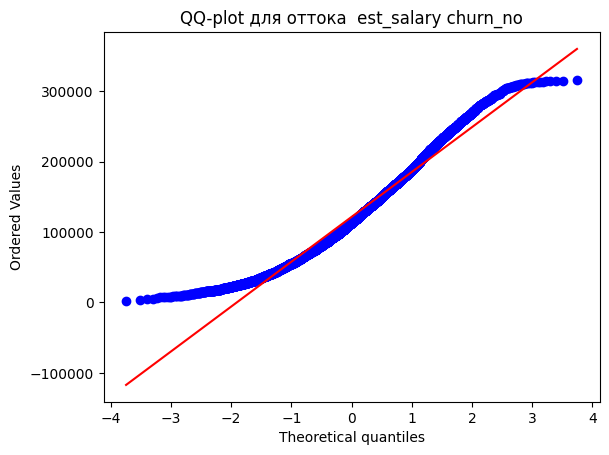

Проверим нормальность распределения выбороки
 Сформируем гипотезы:

    H0 - распределение выборки соответсвует нормальному

    H1 - распределение выборки не является нормальным

K-squared test: p-value = 1.8623789952635908e-84
Распределение не нормальное (отвергаем H0)
Количество данных в группе churn_yes 1726


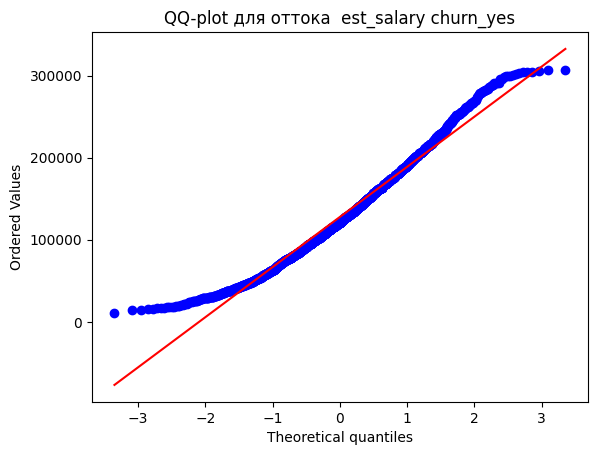

Проверим нормальность распределения выбороки
 Сформируем гипотезы:

    H0 - распределение выборки соответсвует нормальному

    H1 - распределение выборки не является нормальным

K-squared test: p-value = 1.962964271320483e-15
Распределение не нормальное (отвергаем H0)
Проверим равенство дисперсий двух выборок
 Сформируем гипотезы:

    H0 - дисперсии выборок одинаковые

    H1 - существует статистически значимая разница между дисперсиями выборок

Levene's Test: p-value = 0.00600169464820142
Дисперсии не равны (отвергаем H0)
Выдвинем гипотезы: 

    H0:статистически значимой разницы между выборками нет 

    H1:у выборок есть статистически значимая разница 


Используем t-тест с поправкой Уэлча
Результат теста: p-value = 0.00017661940720355263
Есть статистически значимые различия между группами


In [28]:
analyze_continuous_feature(churn_yes, churn_no, 'est_salary')

Выборки не нормально распределены, а также имеют разные дисперсии.
Мы смогли отвергнуть нулевую гипотезу, p value ниже порога 0.05 , можно сказать о статистически значимой разнице зарплат у клиентов оттока и не оттока

<h1 style="font-size: 16px;">гипотеза 2</h1> Баланс у клиентов оттока и которые остались разный
Выдвинем гипотезы:

* H0: Нет статистически значимой разницы между балансом у клиентов которые ушли и которые остались
* H1: Присутствует статистически значимая разница между балансом групп

Анализ признака: balance

Выбросы удалены: в группе 'Не ушедшие' - 240, в группе 'Ушедшие' - 82
Осталось наблюдений: 'Не ушедшие' - 5586, 'Ушедшие' - 1688

Проверка нормальности распределения:
Количество данных в группе churn_no 5586


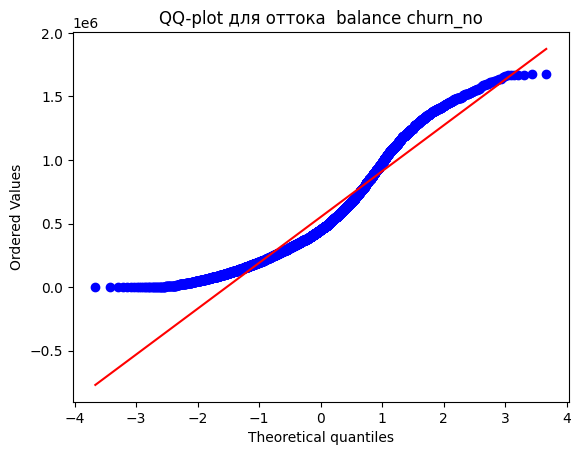

Проверим нормальность распределения выбороки
 Сформируем гипотезы:

    H0 - распределение выборки соответсвует нормальному

    H1 - распределение выборки не является нормальным

K-squared test: p-value = 3.327058734838597e-111
Распределение не нормальное (отвергаем H0)
Количество данных в группе churn_yes 1688


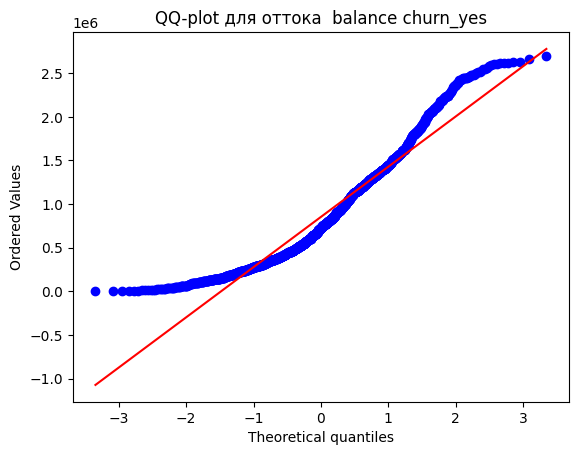

Проверим нормальность распределения выбороки
 Сформируем гипотезы:

    H0 - распределение выборки соответсвует нормальному

    H1 - распределение выборки не является нормальным

K-squared test: p-value = 1.8239695021134082e-34
Распределение не нормальное (отвергаем H0)
Проверим равенство дисперсий двух выборок
 Сформируем гипотезы:

    H0 - дисперсии выборок одинаковые

    H1 - существует статистически значимая разница между дисперсиями выборок

Levene's Test: p-value = 1.689183334430542e-116
Дисперсии не равны (отвергаем H0)
Выдвинем гипотезы: 

    H0:статистически значимой разницы между выборками нет 

    H1:у выборок есть статистически значимая разница 


Используем t-тест с поправкой Уэлча
Результат теста: p-value = 6.904347847866276e-79
Есть статистически значимые различия между группами


In [29]:
analyze_continuous_feature(churn_yes, churn_no, 'balance')

Выборки не нормально распределены, а также имеют разные дисперсии. Мы смогли отвергнуть нулевую гипотезу, p value ниже порога 0.05, можно сказать о статистически значимой разнице в балансе у клиентов оттока и не оттока

In [30]:
def analyze_binary_feature(df, feature, target='churn'):
    print(f"Анализ бинарного признака: {feature}")
    
    # Создание таблицы сопряжённости
    contingency_table = pd.crosstab(df[feature], df[target])
    contingency_table['процент ухода в %'] = contingency_table[1] / contingency_table[0] *100
    print("Таблица сопряжённости:") 
    print(contingency_table)
    print('Разница между признаками', round(contingency_table['процент ухода в %'][0]-contingency_table['процент ухода в %'][1],2))
    # Z-тест для пропорций
    out = np.array([contingency_table.loc[1, 1], contingency_table.loc[0, 1]])  # Ушедшие клиенты
    total = np.array([contingency_table.loc[1, :].sum(), contingency_table.loc[0, :].sum()])  # Все клиенты
    stat, p = proportions_ztest(out, total)
    print(f"Z-тест для пропорций: p-value = {p}")
    if p > 0.05:
        print("Нет статистически значимых различий между группами")
    else:
        print("Есть статистически значимые различия между группами")

C помощью Z теста для пропорций можем выделить является ли статистически значимой разница между бинарными данными

<h1 style="font-size: 16px;">гипотеза 3</h1> уровень оттока у владельцев кредитных карт отличается от уровня оттока клиентов без кредитных карт

* H0: Нет статистически значимой разницы между оттоком владельцев и не владельцев кредитных карт
* H1: есть статистически значимая разница между оттоком владельцев и не владельцев кредитных карт

In [31]:
analyze_binary_feature(df, 'credit_card')

Анализ бинарного признака: credit_card
Таблица сопряжённости:
churn           0    1  процент ухода в %
credit_card                              
0            2339  796          34.031637
1            5677  985          17.350713
Разница между признаками 16.68
Z-тест для пропорций: p-value = 8.22797699939692e-36
Есть статистически значимые различия между группами


Смогли отвергнуть H0, клиенты не владеющие кредитными картами на 16.68% чаще уходят чем те кто ими владеет

<h1 style="font-size: 16px;">гипотеза 4</h1> уровень оттока у активных клиентов отличается от уровня оттока не активных клиентов

* H0: Нет статистически значимой разницы между оттоком активных и не активных клиентов
* H1: есть статистически значимая разница между активными и не активными клиентами

In [32]:
analyze_binary_feature(df, 'last_activity')

Анализ бинарного признака: last_activity
Таблица сопряжённости:
churn             0     1  процент ухода в %
last_activity                               
0              4149   536          12.918776
1              3867  1245          32.195500
Разница между признаками -19.28
Z-тест для пропорций: p-value = 6.434019478817699e-61
Есть статистически значимые различия между группами


Смогли отбросить H0, тогда сделаем вывод, что активные клиенты на 19.28% уходят чаще чем не активные

### Промежуточный вывод

В ходе работы по анализу данных мы построили распределения признаков, удалили выбросы. Расмотрели распределения в разрезе целевой переменной - оттока клиентов. Провели корреляционный анализ, выделили положительную зависимость оттока и количества products, equity и balance. Построили профиль профиля клиента по оттоку, а также провели статистическое исследование признаков в разрезе оттока.

Приведем признаки подходящие для сегментации:

* клиенты из Ярославля и Ростова, имеют более высокий уровень оттока 
* мужчины чаще уходят из банка, чем женщины.
* клиенты в возрасте от 25-35 лет и в возрасте 50-60 лет уходят чаще остальных
* в значительной степени преобладает уход клиентов со счетом баланса выше 1 млн рублей
* активные клиенты, больше всего подвержены оттоку.
* клиенты не владеющие кредитными картами больше поддвержены оттоку
* клиенты у которых количество продуктов выше 2 чаще подвержены оттоку
* клиенты у которых количество очков equity выше 3 чаще подвержены оттоку
* клиенты с score от 850 до 900 уходят чаще

### Сегментирование клиентов

Создадим сегменты клиентов по статистически значимым признакам, разделим признаки на отрезки по которым выделим наибольший процент оттока.

<h1 style="font-size: 16px;">сегмент 1</h1>

Клиенты из Ярославля или Ростова, не имеющие кредитных карт в возрасте 25-35 лет

In [33]:
segment_1 = (
    df.query('(age < 35 and age > 20) and (city == "Ярославль" or city == "Ростов") and credit_card == 0')
    .agg({'churn':['mean','count']})
)
print(segment_1)
print('Среднебанковский отток клиентов', round(df['churn'].mean(),2))

            churn
mean     0.372277
count  505.000000
Среднебанковский отток клиентов 0.18


Сегмент имеет отток выше среднебанковского, сегмент имеет право на реализацию

<h1 style="font-size: 16px;">сегмент 2</h1>

Клиенты с балансом выше 1 млн и являющиеся активными клиентами банка

In [34]:
segment_2 = (
    df.query('balance > 1000000 and last_activity == 1')
    .agg({'churn':['mean','count']})
)
print(segment_2)
print('Среднебанковский отток клиентов', round(df['churn'].mean(),2))

            churn
mean     0.522678
count  926.000000
Среднебанковский отток клиентов 0.18


Сегмент имеет отток выше среднебанковского, сегмент имеет право на реализацию

<h1 style="font-size: 16px;">сегмент 3</h1> 
Клиенты в возрасте от 50-65 лет с очками equity выше 3

In [35]:
segment_3 = (
    df.query('(age < 65 and age > 50) and equity > 3')
    .agg({'churn':['mean','count']})
)
print(segment_3)
print('Среднебанковский отток клиентов', round(df['churn'].mean(),2))

            churn
mean     0.334975
count  812.000000
Среднебанковский отток клиентов 0.18


Сегмент имеет отток выше среднебанковского, сегмент имеет право на реализацию

### Приотеризация сегментов

По приотеризации сегментов будем основываться на среднем оттоке сегмента.
1. Клиенты с балансом выше 1 млн и являющиеся активными клиентами банка
2. Клиенты из Ярославля или Ростова, не имеющие кредитных карт в возрасте 25-35 лет
3. Клиенты в возрасте от 50-65 лет с очками equity выше 3


### Рекомендации по работе с приоритетными сегментами

<h1 style="font-size: 16px;">сегмент 1</h1> Клиенты из Ярославля или Ростова, не имеющие кредитных карт в возрасте 25-35 лет

* разработка специальной молодежной кредитной карты с повышенным кешбеком на рестораны, фастфуд, развлечения и так далее
* акция приведи друга в Ростове и Ярославле с целью открытия кредитной карты

<h1 style="font-size: 16px;">сегмент 2</h1> Клиенты с балансом выше 1 млн и являющиеся активными клиентами банка

* формирование системы привилегированного обслуживания для клиентов с высоким балансом
* назначение персонального менеджера для подборки индивидуальных условий для каждого клиента

<h1 style="font-size: 16px;">сегмент 3</h1> Клиенты в возрасте 50-65 лет и с очками equity выше 3

* Бесплатные юридические/финансовые консультации
* Пониженная ставка на ипотеку или рефинансирование

### Презентация

https://disk.yandex.ru/i/D27UdekJGTEv8Q